In [20]:
!pip install torch torchvision ftfy regex tqdm git+https://github.com/openai/CLIP.git
!pip install scipy
!pip install datasets
!pip install evaluate rouge_score


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-sxynaqiq
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-sxynaqiq
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [21]:
import torchvision.transforms as transforms
from torchvision.models.inception import inception_v3
from torch.nn import functional as F
from PIL import Image
import os
from tqdm import tqdm
import clip
import numpy as np
from scipy.stats import entropy

In [22]:
import torch, json, os, random
from PIL import Image
from tqdm import tqdm
from transformers import BlipProcessor, BlipForConditionalGeneration
from diffusers import StableDiffusionPipeline
from google.colab import drive

# Access Google Drive
drive.mount('/content/drive')
blip_model_path = "/content/drive/MyDrive/blip_model"

# Load BLIP model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = BlipProcessor.from_pretrained(blip_model_path, local_files_only=True)
blip_model = BlipForConditionalGeneration.from_pretrained(blip_model_path, local_files_only=True).to(device)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# Load CelebA image paths manually from Google Drive
img_dir = "/content/drive/MyDrive/celeba"
filenames = sorted(os.listdir(img_dir))[:40]

In [24]:

# Caption modification function
def modify_caption(caption):
    styles = ["professional photo", "animated version", "art style", "fashion photo", "magazine look"]
    noise = ["random objects", "blurry light", "chaotic texture", "strange background", "weird shapes"]
    return {
        "original_caption": caption,
        "style_caption": caption + ", " + random.choice(styles),
        "noisy_caption": caption + ", " + random.choice(noise)
    }

# Step 1: Generate original and modified captions using BLIP
captions = {}
os.makedirs("captions", exist_ok=True)
for idx in tqdm(range(len(filenames))):
    image_path = os.path.join(img_dir, filenames[idx])
    image = Image.open(image_path).resize((224, 224)).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    out = blip_model.generate(**inputs)
    raw_caption = processor.decode(out[0], skip_special_tokens=True)
    captions[filenames[idx]] = modify_caption(raw_caption)

with open("captions/celeba_captions.json", "w") as f:
    json.dump(captions, f, indent=2)

# Step 2: Generate images with Stable Diffusion
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
os.makedirs("outputs_sd/celeba/original", exist_ok=True)
os.makedirs("outputs_sd/celeba/style", exist_ok=True)
os.makedirs("outputs_sd/celeba/noisy", exist_ok=True)

for name, data in captions.items():
    image_orig = pipe(data["original_caption"]).images[0]
    image_orig.save(os.path.join("outputs_sd/celeba/original", name))

    image_style = pipe(data["style_caption"]).images[0]
    image_style.save(os.path.join("outputs_sd/celeba/style", name))

    image_noise = pipe(data["noisy_caption"]).images[0]
    image_noise.save(os.path.join("outputs_sd/celeba/noisy", name))

# Step 3: Recaption all generated images
regen_captions = {"original": {}, "style": {}, "noisy": {}}

for name in tqdm(captions.keys()):
    for variant in ["original", "style", "noisy"]:
        path = os.path.join(f"outputs_sd/celeba/{variant}", name)
        image = Image.open(path).resize((224, 224)).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(device)
        out = blip_model.generate(**inputs)
        regen_captions[variant][name] = processor.decode(out[0], skip_special_tokens=True)

os.makedirs("regenerated_captions", exist_ok=True)
with open("regenerated_captions/celeba_sd_captions_extended.json", "w") as f:
    json.dump(regen_captions, f, indent=2)



100%|██████████| 40/40 [00:08<00:00,  4.66it/s]


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


In [25]:
import evaluate
import json
import pandas as pd

# Load ROUGE
rouge = evaluate.load("rouge")

# Load captions and recaptions
with open("captions/celeba_captions.json", "r") as f:
    original_caps = json.load(f)

with open("regenerated_captions/celeba_sd_captions_extended.json", "r") as f:
    recaptioned = json.load(f)

# ---- ROUGE SCORE ----
results = {
    "image_name": [],
    "rougeL_orig_vs_recap_orig": [],
    "rougeL_style_vs_recap_style": [],
    "rougeL_noisy_vs_recap_noisy": [],
    "rougeL_orig_vs_recap_style": [],
    "rougeL_orig_vs_recap_noisy": []
}

def get_rougeL(pred, ref):
    score = rouge.compute(predictions=[pred], references=[ref], use_stemmer=True)
    return score["rougeL"]

for name in original_caps:
    orig_cap = original_caps[name]["original_caption"]
    style_cap = original_caps[name]["style_caption"]
    noisy_cap = original_caps[name]["noisy_caption"]

    rec_orig = recaptioned["original"][name]
    rec_style = recaptioned["style"][name]
    rec_noisy = recaptioned["noisy"][name]

    results["image_name"].append(name)
    results["rougeL_orig_vs_recap_orig"].append(get_rougeL(rec_orig, orig_cap))
    results["rougeL_style_vs_recap_style"].append(get_rougeL(rec_style, style_cap))
    results["rougeL_noisy_vs_recap_noisy"].append(get_rougeL(rec_noisy, noisy_cap))
    results["rougeL_orig_vs_recap_style"].append(get_rougeL(rec_style, orig_cap))
    results["rougeL_orig_vs_recap_noisy"].append(get_rougeL(rec_noisy, orig_cap))

pd.DataFrame(results).to_csv("caption_consistency_rouge_celeba.csv", index=False)


In [26]:
# Load CLIP
clip_model, preprocess_clip = clip.load("ViT-B/32", device=device)

# Load InceptionV3
inception = inception_v3(pretrained=True, transform_input=False).to(device)
inception.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [27]:
def load_image(path, size=(299, 299), for_clip=False):
    image = Image.open(path).convert("RGB")
    if for_clip:
        return preprocess_clip(image).unsqueeze(0).to(device)
    else:
        transform = transforms.Compose([
            transforms.Resize(size),
            transforms.CenterCrop(size),
            transforms.ToTensor()
        ])
        return transform(image).unsqueeze(0).to(device)


In [28]:
def get_inception_score(images, splits=1):
    preds = []
    with torch.no_grad():
        for img in tqdm(images):
            img = load_image(img)
            pred = inception(img)
            pred = F.softmax(pred, dim=1)
            preds.append(pred.cpu().numpy())
    preds = np.concatenate(preds, axis=0)

    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds) // splits): (k+1) * (len(preds) // splits), :]
        py = np.mean(part, axis=0)
        scores = [entropy(pyx, py) for pyx in part]
        split_scores.append(np.exp(np.mean(scores)))
    return np.mean(split_scores), np.std(split_scores)


In [29]:
def compute_clip_similarity(image_paths, captions):
    scores = []
    with torch.no_grad():
        for path, caption in tqdm(zip(image_paths, captions), total=len(image_paths)):
            image_input = load_image(path, for_clip=True)
            text_input = clip.tokenize(caption).to(device)
            image_features = clip_model.encode_image(image_input)
            text_features = clip_model.encode_text(text_input)
            sim = F.cosine_similarity(image_features, text_features).item()
            scores.append(sim)
    return scores


In [30]:
# ---- PATH SETUP ----
base_path = "outputs_sd/celeba/"
original_images = [os.path.join(base_path, "original", f) for f in os.listdir(base_path + "original")]
style_images = [os.path.join(base_path, "style", f) for f in os.listdir(base_path + "style")]
noisy_images = [os.path.join(base_path, "noisy", f) for f in os.listdir(base_path + "noisy")]

# ---- SCORE COMPUTATION ----
inception_orig, _ = get_inception_score(original_images)
inception_style, _ = get_inception_score(style_images)
inception_noisy, _ = get_inception_score(noisy_images)

clip_scores_orig = compute_clip_similarity(original_images, [original_caps[f]["original_caption"] for f in original_caps])
clip_scores_style = compute_clip_similarity(style_images, [original_caps[f]["style_caption"] for f in original_caps])
clip_scores_noisy = compute_clip_similarity(noisy_images, [original_caps[f]["noisy_caption"] for f in original_caps])

clip_data = {
    "image_name": list(original_caps.keys()),
    "clip_original": clip_scores_orig,
    "clip_style": clip_scores_style,
    "clip_noisy": clip_scores_noisy,
    "inception_original": [inception_orig] * len(clip_scores_orig),
    "inception_style": [inception_style] * len(clip_scores_style),
    "inception_noisy": [inception_noisy] * len(clip_scores_noisy),
}

df_clip = pd.DataFrame(clip_data)
df_clip.to_csv("clip_inception_celeba.csv", index=False)


100%|██████████| 40/40 [00:01<00:00, 38.82it/s]


In [31]:
import pandas as pd

# Load files
df_rouge = pd.read_csv("caption_consistency_rouge_celeba.csv")
df_clip_inception = pd.read_csv("clip_inception_celeba.csv")

# Compute means
mean_rouge = {
    "ROUGE-L: orig vs recap_orig": df_rouge["rougeL_orig_vs_recap_orig"].mean(),
    "ROUGE-L: style vs recap_style": df_rouge["rougeL_style_vs_recap_style"].mean(),
    "ROUGE-L: noisy vs recap_noisy": df_rouge["rougeL_noisy_vs_recap_noisy"].mean(),
    "ROUGE-L: orig vs recap_style": df_rouge["rougeL_orig_vs_recap_style"].mean(),
    "ROUGE-L: orig vs recap_noisy": df_rouge["rougeL_orig_vs_recap_noisy"].mean()
}


mean_clip = {
    "CLIP (original)": df_clip_inception["clip_original"].mean(),
    "CLIP (style)": df_clip_inception["clip_style"].mean(),
    "CLIP (noisy)": df_clip_inception["clip_noisy"].mean()
}

mean_inception = {
    "Inception (original)": df_clip_inception["inception_original"].mean(),
    "Inception (style)": df_clip_inception["inception_style"].mean(),
    "Inception (noisy)": df_clip_inception["inception_noisy"].mean()
}

# Combine all
summary = {
    "Metric": list(mean_rouge.keys()) + list(mean_clip.keys()) + list(mean_inception.keys()),
    "Mean Score": list(mean_rouge.values()) + list(mean_clip.values()) + list(mean_inception.values())
}

df_summary = pd.DataFrame(summary)
df_summary.to_csv("summary_scores_celeb.csv", index=False)
print(df_summary)

                           Metric  Mean Score
0     ROUGE-L: orig vs recap_orig    0.604108
1   ROUGE-L: style vs recap_style    0.550057
2   ROUGE-L: noisy vs recap_noisy    0.493201
3    ROUGE-L: orig vs recap_style    0.610259
4    ROUGE-L: orig vs recap_noisy    0.551447
5                 CLIP (original)    0.187674
6                    CLIP (style)    0.193515
7                    CLIP (noisy)    0.187488
8            Inception (original)    6.394276
9               Inception (style)    6.139854
10              Inception (noisy)    5.617953


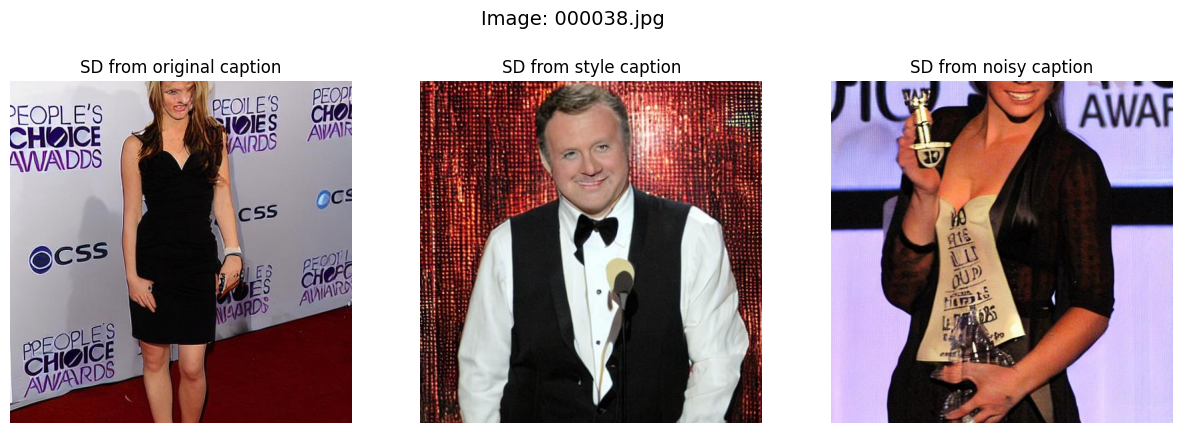

Original Caption: charlie mott at the 2010 people ' s choice awards
Style Caption: charlie mott at the 2010 people ' s choice awards, professional photo
Noisy Caption: charlie mott at the 2010 people ' s choice awards, blurry light

🔁 Re-Captions:
  • From SD(original): a woman in a black dress on a red carpet
  • From SD(style):    a man in a tuxed tuxed tuxed tuxed tuxed tuxed tuxed tuxed
  • From SD(noisy):    a woman holding a trophy in her hand


In [32]:
import matplotlib.pyplot as plt
from PIL import Image
import json


df = df_rouge.merge(df_clip_inception, on="image_name")

# Normalize scores for each variant (lower = worse)
df["rouge_orig_norm"] = 1 - df["rougeL_orig_vs_recap_orig"]
df["rouge_style_norm"] = 1 - df["rougeL_style_vs_recap_style"]
df["rouge_noisy_norm"] = 1 - df["rougeL_noisy_vs_recap_noisy"]

df["clip_orig_norm"] = 1 - df["clip_original"]
df["clip_style_norm"] = 1 - df["clip_style"]
df["clip_noisy_norm"] = 1 - df["clip_noisy"]

# Combine drift scores for all 3 types
df["combined_drift"] = (
    df["rouge_orig_norm"] + df["clip_orig_norm"] +
    df["rouge_style_norm"] + df["clip_style_norm"] +
    df["rouge_noisy_norm"] + df["clip_noisy_norm"]
)

# Find top 1 worst drifting examples
worst = df.sort_values("combined_drift", ascending=False).head(1)["image_name"].tolist()


# Load captions and recaptions for CelebA
with open("captions/celeba_captions.json") as f:
    captions = json.load(f)
with open("regenerated_captions/celeba_sd_captions_extended.json") as f:
    recaps = json.load(f)

def show_qualitative_example_celeba(image_name):
    # Paths to CelebA images
    base_path = "outputs_sd/celeba"
    img_paths = {
        "original": f"{base_path}/original/{image_name}",
        "style": f"{base_path}/style/{image_name}",
        "noisy": f"{base_path}/noisy/{image_name}"
    }

    # Display images side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, variant in enumerate(["original", "style", "noisy"]):
        img = Image.open(img_paths[variant])
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"SD from {variant} caption")

    plt.suptitle(f"Image: {image_name}", fontsize=14)
    plt.show()

    # Print captions and recaptions
    print(f"\033[1mOriginal Caption:\033[0m {captions[image_name]['original_caption']}")
    print(f"\033[1mStyle Caption:\033[0m {captions[image_name]['style_caption']}")
    print(f"\033[1mNoisy Caption:\033[0m {captions[image_name]['noisy_caption']}")
    print()
    print("🔁 Re-Captions:")
    print(f"  • From SD(original): {recaps['original'][image_name]}")
    print(f"  • From SD(style):    {recaps['style'][image_name]}")
    print(f"  • From SD(noisy):    {recaps['noisy'][image_name]}")

for name in worst:
    show_qualitative_example_celeba(name)